# Match Trigger and Event Catalog

## Import Libraries

In [1]:
import os, sys
import obspy as obs
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client
from obspy.signal.trigger import coincidence_trigger
from numpy import sort, argmin, array
from pandas import DataFrame

from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth
from functions.catalog_to_dataframe import __catalog_to_dataframe

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [20]:
config = {}

config['time_period'] = "20221001_20230615"

config['BSPF_lon'] = array([-116.455439])
config['BSPF_lat'] = array([33.610643])

config['path_to_catalogs'] = data_path+"BSPF/data/catalogs/"

config['catalog_filename'] = f"BSPF_catalog_{config['time_period']}_all.xml"

config['output_filename'] = f"BSPF_catalog_{config['time_period']}_triggered.xml"

config['client'] = Client("IRIS")

In [4]:
!ls /home/andbro/kilauea-data/BSPF/data/catalogs

BSPF_catalog_20221001_20230331_triggered.pkl
BSPF_catalog_20221001_20230331_triggered.xml
BSPF_catalog_20221001_20230531_all.pkl
BSPF_catalog_20221001_20230531_all.xml
BSPF_catalog_20221001_20230615_all.pkl
BSPF_catalog_20221001_20230615_all.xml
BSPF_catalog_20221001_20230615_triggered.pkl
BSPF_catalog_extended_20221001_20230531_all.pkl
BSPF_catalog_extended_20221001_20230531_all.xml
BSPF_catalog_extended_20221001_20230615_all.pkl
BSPF_catalog_extended_20221001_20230615_all.xml
gcmt_solutions_20221001_20230531.xml
gcmt_solutions_20221001_20230615.xml
tmp
trigger_20221001_20230331.pkl
trigger_20221001_20230615.pkl
trigger_20230401_20230615.pkl
trigger_all_errors.pkl


##  join catalogs

In [5]:
# from andbro__store_as_pickle import __store_as_pickle

# trigger_old = __read_pickle(config, config['path_to_catalogs'], "trigger_20221001_20230331.pkl")
# trigger_new = __read_pickle(config, config['path_to_catalogs'], "trigger_20230401_20230615.pkl")
# trigger_all = trigger_old + trigger_new

# print(len(trigger_old), len(trigger_new), len(trigger_all))

# __store_as_pickle(trigger_all, config['path_to_catalogs']+"trigger_20221001_20230615.pkl")

## Load Triggered Events

In [6]:
def __read_pickle(config, path, filename):
    
    import pickle

    with open(path+filename, 'rb') as f:
        triggerfile = pickle.load(f)
        
    return triggerfile

In [21]:
trigger_events = __read_pickle(config, config['path_to_catalogs'], f"trigger_{config['time_period']}.pkl")

In [22]:
times, cosum = [], []
ref_time = obs.UTCDateTime("2022-10-01")

for trig in trigger_events:
    times.append(trig['time'])
    cosum.append(trig['coincidence_sum'])
    
rel_times = [(t-ref_time)/86400 for t in times]
trigger_times = [t for t in times]

In [23]:
## read catalog
cat = obs.read_events(config['path_to_catalogs']+config['catalog_filename'])

print(len(cat), len(trigger_events))

7578 100


## Match events of triggered catalog with event catalog

In [24]:
def __find_matches(trigger_times, catalog, max_time_difference=60):

    from numpy import array
    
    matches, time_diffs, events_triggered, event_idxs = [], [], [], []

    ## extract origin times from catalog
    event_times = [catalog.events[j].origins[0].time for j in range(len(catalog))]
    
    
    for trigger_time in trigger_times:

        ## compute time differences in seconds
        diff = [event_time-trigger_time for event_time in event_times]
        
        ## only the ones before the trigger in time
        abs_diff = [abs(d) for d in diff if d < 0]
        
        ## get closest event
        t_min, t_idx = min(abs_diff), diff.index(-min(abs_diff))
                
        time_diffs.append(t_min)
        matches.append(trigger_time)
        events_triggered.append(event_times[t_idx])
        event_idxs.append(t_idx)
        
    cat_sel = [cat.events[idx] for idx in event_idxs]
        
        
    t_days = [(match-obs.UTCDateTime("2022-10-01"))/86400 for match in matches]
    plt.figure(figsize=(15,5))
    plt.scatter(t_days, time_diffs, zorder=2, s=5)
    plt.yscale("log")
    plt.grid(which="both", zorder=-1, ls=":")
    plt.ylabel("Time Differences (s)")
    plt.xlabel("Time (days)")
    plt.xlim(0, 190)
    
    return array(matches), array(events_triggered), cat_sel

(100, 100)

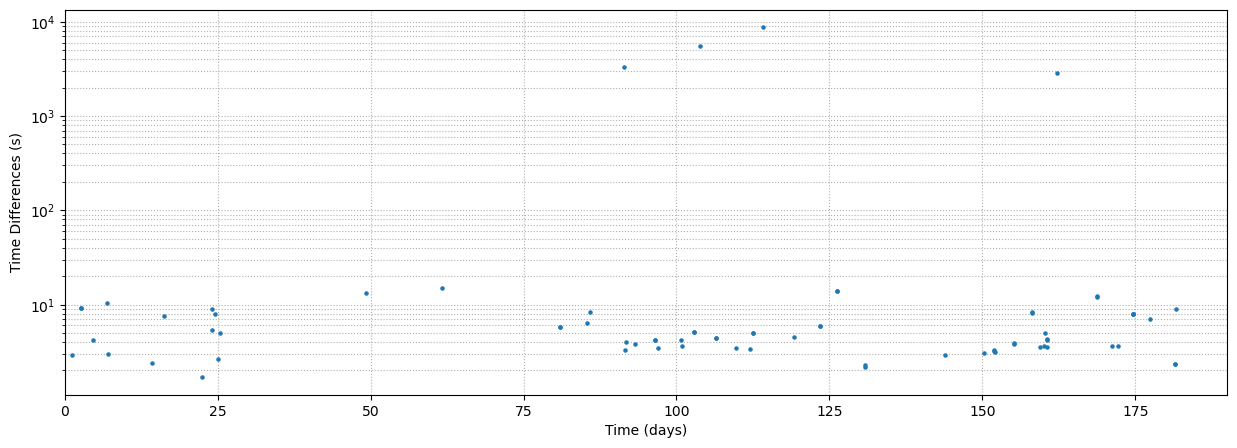

In [25]:
matches, events_triggered, cat_select = __find_matches(trigger_times, cat, max_time_difference=60)

len(events_triggered), len(matches)

## Create Catalog of triggered events that were matched with catalog events

In [26]:
cata = obs.Catalog()
for ev in cat_select:
    cata += ev

cata.write(config['path_to_catalogs']+config['output_filename'], format="QUAKEML")
print(f" -> storing: {config['path_to_catalogs']}{config['output_filename']} ...")

 -> storing: /home/andbro/kilauea-data/BSPF/data/catalogs/BSPF_catalog_20221001_20230615_triggered.xml ...


In [37]:
cata_df = __catalog_to_dataframe(cata)

cata_df['seconds'] = [abs((cata_df.index.min()-tt).total_seconds()) for tt in cata_df.index]
cata_df['trigger_time'] = trigger_times
cata_df['cosum'] = cosum
data_df = __add_distances_and_backazimuth(config['BSPF_lat'], config['BSPF_lon'], cata_df)


cata_df.to_pickle(config['path_to_catalogs']+config['output_filename'].replace(".xml",".pkl"))
print(f" -> storing: {config['path_to_catalogs']}{config['output_filename'].replace('.xml','.pkl')}...")

 -> storing: /home/andbro/kilauea-data/BSPF/data/catalogs/BSPF_catalog_20221001_20230615_triggered.pkl...
